In [1]:
# Oscar Winner Prediction Analysis
# Random Forest Classifier, Probit Model, Logistic Regression, CatBoost, and XGBoost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries loaded successfully!")

Libraries loaded successfully!


# 1. Data Loading and Exploration

Loading the merged dataset with Oscar nominees and winners from multiple sources (Wikipedia, IMDB, Letterboxd).


In [2]:
# Load the dataset
df = pd.read_csv('/workspaces/DataDriveOscarProject/DataAnalysis/merged_df_final.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (612, 29)

Columns: ['Year of Film Release', 'Film_wiki', 'Film Studio/Producer(s)', 'is_winner', 'clean_name', 'year', 'Film_imdb', 'url_tried', 'rating', 'keywords', 'stars', 'user_reviews', 'critic_reviews', 'metascore', 'cast_number', 'longitud', 'imdb_url', 'url_used', 'found', 'found_in_imdb', 'description', 'rating_letterboxd', 'number_of_lists', 'number_of_watches', 'number_of_likes', 'number_of_fans', 'name_of_director', 'film_name', 'found_in_letterboxd']

First few rows:


,Year of Film Release,Film_wiki,Film Studio/Producer(s),is_winner,clean_name,year,Film_imdb,url_tried,rating,keywords,...,found_in_imdb,description,rating_letterboxd,number_of_lists,number_of_watches,number_of_likes,number_of_fans,name_of_director,film_name,found_in_letterboxd
0,1927/28 (1st),Wings,"Famous Players–Lasky (Lucien Hubbard, Jesse L....",True,wings-1927,1927.0,Wings,https://letterboxd.com/film/wings-1927,7.5,"['Coming-of-Age', 'War Epic', 'Action', 'Drama...",...,True,"YOUTH, HITTING THE CLOUDS! LAUGHING AT DANGER!...",3.8,28K,29K,7K,87 FANS,William A. Wellman,wings-1927,True
1,1927/28 (1st),7th Heaven,"Fox (William Fox, producer)",False,7th-heaven-1927,1927.0,7th Heaven,https://letterboxd.com/film/7th-heaven-1927,7.5,"['Drama', 'Romance']",...,True,"In 1910s Paris, a sewer worker disillusioned w...",3.7,12K,8.2K,2K,41 FANS,Frank Borzage,7th-heaven-1927,True
2,1927/28 (1st),The Racket,"The Caddo Company (Howard Hughes, producer)",False,the-racket-1927,1928.0,The Racket,https://letterboxd.com/film/the-racket-1927,6.6,"['Film Noir', 'Crime', 'Drama']",...,True,A renegade police captain sets out to catch a ...,3.1,4.2K,2.6K,318,2 FANS,Lewis Milestone,the-racket-1927,True
3,1928/29 (2nd) [a],The Broadway Melody,Metro-Goldwyn-Mayer (Irving Thalberg & Lawrenc...,True,the-broadway-melody-1928,1929.0,The Broadway Melody,https://letterboxd.com/film/the-broadway-melod...,5.5,"['Classic Musical', 'Showbiz Drama', 'Drama', ...",...,True,ALL TALKING. ALL SINGING. ALL DANCING.\nThe va...,2.4,17K,13K,730,2 FANS,Harry Beaumont,the-broadway-melody-1928,True
4,1928/29 (2nd) [a],Alibi,"Feature Productions (Roland West, producer)",False,alibi-1928,1931.0,Alibi,https://letterboxd.com/film/alibi-1928,7.4,['Mystery'],...,True,Belgian sleuth Hercule Poirot investigates a m...,NaN,161,23,1,NaN,Leslie S. Hiscott,alibi-1928,True


In [3]:
df['number_of_lists'] = df['number_of_lists'].apply(lambda x: str(float(x.replace('K', '')) * 1000) if 'K' in x else x)
df['number_of_lists'] = df['number_of_lists'].apply(lambda x: str(float(x.replace('M', '')) * 1000000) if 'M' in x else x)


df['number_of_watches'] = df['number_of_watches'].apply(lambda x: str(float(x.replace('K', '')) * 1000) if 'K' in x else x)
df['number_of_watches'] = df['number_of_watches'].apply(lambda x: str(float(x.replace('M', '')) * 1000000) if 'M' in x else x)

df['number_of_likes'] = df['number_of_likes'].apply(lambda x: str(float(x.replace('K', '')) * 1000) if 'K' in x else x)
df['number_of_likes'] = df['number_of_likes'].apply(lambda x: str(float(x.replace('M', '')) * 1000000) if 'M' in x else x)

df['user_reviews'] = df['user_reviews'].apply(lambda x: str(float(str(x).replace('K', '')) * 1000) if 'K' in str(x) else x)
df['user_reviews'] = df['user_reviews'].apply(lambda x: str(float(str(x).replace('M', '')) * 1000000) if 'M' in str(x) else x)

df['critic_reviews'] = df['critic_reviews'].apply(lambda x: str(float(str(x).replace('K', '')) * 1000) if 'K' in str(x) else x)
df['critic_reviews'] = df['critic_reviews'].apply(lambda x: str(float(str(x).replace('M', '')) * 1000000) if 'M' in str(x) else x)

df['number_of_fans'] = df['number_of_fans'].apply(lambda x: str(x).replace(" FANS", ""))
df['number_of_fans'] = df['number_of_fans'].apply(lambda x: str(x).replace(" FAN", ""))
df['number_of_fans'] = df['number_of_fans'].apply(lambda x: str(float(x.replace('K', '')) * 1000) if 'K' in x else x)
df['number_of_fans'] = df['number_of_fans'].apply(lambda x: str(float(x.replace('M', '')) * 1000000) if 'M' in x else x)


In [4]:
# Clean up the numeric columns: replace NaN with 0 and convert to float
df['number_of_lists'] = pd.to_numeric(df['number_of_lists'], errors='coerce').fillna(0)
df['number_of_watches'] = pd.to_numeric(df['number_of_watches'], errors='coerce').fillna(0)
df['number_of_likes'] = pd.to_numeric(df['number_of_likes'], errors='coerce').fillna(0)
df['number_of_fans'] = pd.to_numeric(df['number_of_fans'], errors='coerce').fillna(0)
df['user_reviews'] = pd.to_numeric(df['user_reviews'], errors='coerce').fillna(0)
df['critic_reviews'] = pd.to_numeric(df['critic_reviews'], errors='coerce').fillna(0)


In [5]:
# Basic statistics about the dataset
print("Data Types:")
print(df.dtypes)
print("\n" + "="*50)
print("\nTarget Variable Distribution:")
print(df['is_winner'].value_counts())
print(f"\nPercentage of winners: {df['is_winner'].sum() / len(df) * 100:.2f}%")
print("\n" + "="*50)
print("\nMissing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))


Data Types:
Year of Film Release        object
Film_wiki                   object
Film Studio/Producer(s)     object
is_winner                     bool
clean_name                  object
year                       float64
Film_imdb                   object
url_tried                   object
rating                     float64
keywords                    object
stars                       object
user_reviews               float64
critic_reviews             float64
metascore                  float64
cast_number                float64
longitud                    object
imdb_url                    object
url_used                    object
found                       object
found_in_imdb                 bool
description                 object
rating_letterboxd          float64
number_of_lists            float64
number_of_watches          float64
number_of_likes            float64
number_of_fans             float64
name_of_director            object
film_name                   object
found_in

In [6]:
df.head()

,Year of Film Release,Film_wiki,Film Studio/Producer(s),is_winner,clean_name,year,Film_imdb,url_tried,rating,keywords,...,found_in_imdb,description,rating_letterboxd,number_of_lists,number_of_watches,number_of_likes,number_of_fans,name_of_director,film_name,found_in_letterboxd
0,1927/28 (1st),Wings,"Famous Players–Lasky (Lucien Hubbard, Jesse L....",True,wings-1927,1927.0,Wings,https://letterboxd.com/film/wings-1927,7.5,"['Coming-of-Age', 'War Epic', 'Action', 'Drama...",...,True,"YOUTH, HITTING THE CLOUDS! LAUGHING AT DANGER!...",3.8,28000.0,29000.0,7000.0,87.0,William A. Wellman,wings-1927,True
1,1927/28 (1st),7th Heaven,"Fox (William Fox, producer)",False,7th-heaven-1927,1927.0,7th Heaven,https://letterboxd.com/film/7th-heaven-1927,7.5,"['Drama', 'Romance']",...,True,"In 1910s Paris, a sewer worker disillusioned w...",3.7,12000.0,8200.0,2000.0,41.0,Frank Borzage,7th-heaven-1927,True
2,1927/28 (1st),The Racket,"The Caddo Company (Howard Hughes, producer)",False,the-racket-1927,1928.0,The Racket,https://letterboxd.com/film/the-racket-1927,6.6,"['Film Noir', 'Crime', 'Drama']",...,True,A renegade police captain sets out to catch a ...,3.1,4200.0,2600.0,318.0,2.0,Lewis Milestone,the-racket-1927,True
3,1928/29 (2nd) [a],The Broadway Melody,Metro-Goldwyn-Mayer (Irving Thalberg & Lawrenc...,True,the-broadway-melody-1928,1929.0,The Broadway Melody,https://letterboxd.com/film/the-broadway-melod...,5.5,"['Classic Musical', 'Showbiz Drama', 'Drama', ...",...,True,ALL TALKING. ALL SINGING. ALL DANCING.\nThe va...,2.4,17000.0,13000.0,730.0,2.0,Harry Beaumont,the-broadway-melody-1928,True
4,1928/29 (2nd) [a],Alibi,"Feature Productions (Roland West, producer)",False,alibi-1928,1931.0,Alibi,https://letterboxd.com/film/alibi-1928,7.4,['Mystery'],...,True,Belgian sleuth Hercule Poirot investigates a m...,NaN,161.0,23.0,1.0,0.0,Leslie S. Hiscott,alibi-1928,True


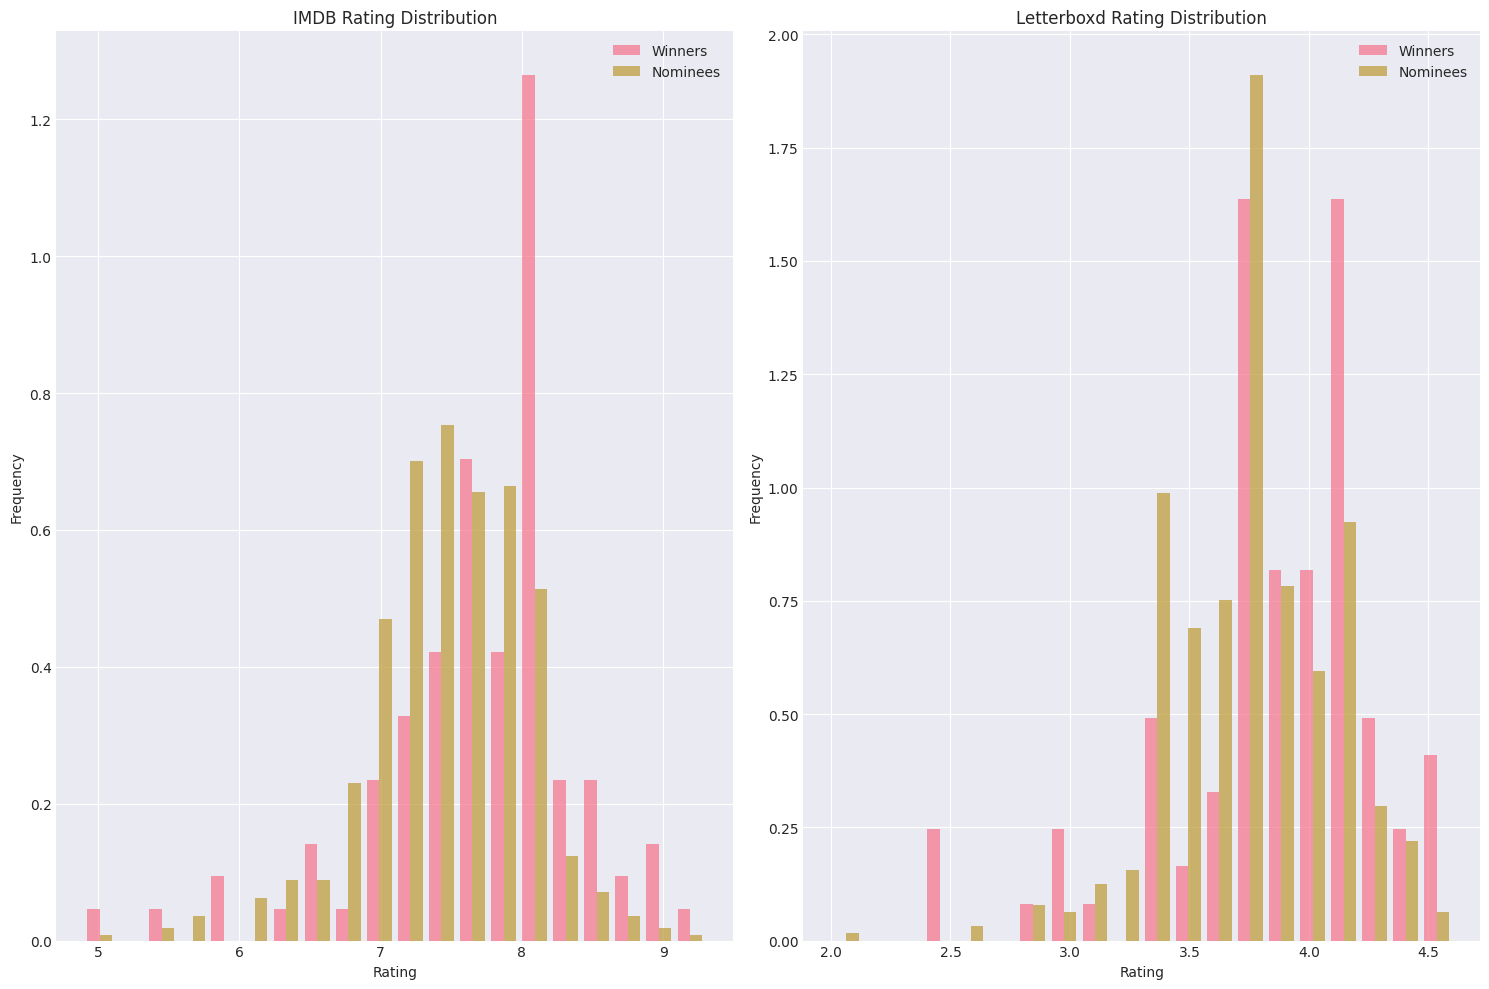

In [7]:
# Visualize the distribution of ratings by winner status
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# IMDB rating distribution
axes[0].hist([df[df['is_winner']==True]['rating'].dropna(), 
              df[df['is_winner']==False]['rating'].dropna()],
             label=['Winners', 'Nominees'], bins=20, alpha=0.7, density=True)
axes[0].set_title('IMDB Rating Distribution')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Letterboxd rating distribution
axes[1].hist([df[df['is_winner']==True]['rating_letterboxd'].dropna(), 
              df[df['is_winner']==False]['rating_letterboxd'].dropna()],
             label=['Winners', 'Nominees'], bins=20, alpha=0.7, density=True)
axes[1].set_title('Letterboxd Rating Distribution')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()


In [8]:
df.columns

Index(['Year of Film Release', 'Film_wiki', 'Film Studio/Producer(s)',
       'is_winner', 'clean_name', 'year', 'Film_imdb', 'url_tried', 'rating',
       'keywords', 'stars', 'user_reviews', 'critic_reviews', 'metascore',
       'cast_number', 'longitud', 'imdb_url', 'url_used', 'found',
       'found_in_imdb', 'description', 'rating_letterboxd', 'number_of_lists',
       'number_of_watches', 'number_of_likes', 'number_of_fans',
       'name_of_director', 'film_name', 'found_in_letterboxd'],
      dtype='object')

# 2. Feature Engineering and Preprocessing

We'll select all available numerical and categorical features, handle missing values using mean imputation, and prepare the data for modeling.


In [9]:
# Create a working copy
df_work = df.copy()

# Convert target to binary (1 for winner, 0 for nominee)
df_work['is_winner'] = df_work['is_winner'].astype(int)


In [10]:
# Create new features based on director nomination history
print("Creating director nomination history features...")

# Initialize new columns
df_work['director_nominated_before'] = 0
df_work['director_num_previous_nominations'] = 0

# Get unique years in chronological order
unique_years = sorted(df_work['year'].unique())

# For each year, check director history in previous years
for current_year in unique_years:
    # Get indices for current year
    current_year_mask = df_work['year'] == current_year
    current_year_indices = df_work[current_year_mask].index
    
    # Get all previous years
    previous_years = [y for y in unique_years if y < current_year]
    
    # For each film in current year
    for idx in current_year_indices:
        director = df_work.loc[idx, 'name_of_director']
        
        # Count nominations in previous years
        previous_nominations = df_work[
            (df_work['year'].isin(previous_years)) & 
            (df_work['name_of_director'] == director)
        ].shape[0]
        
        # Set the features
        df_work.loc[idx, 'director_nominated_before'] = 1 if previous_nominations > 0 else 0
        df_work.loc[idx, 'director_num_previous_nominations'] = previous_nominations

print("Director nomination history features created!")
print(f"\nDirector feature statistics:")
print(f"Films with director previously nominated: {(df_work['director_nominated_before'] == 1).sum()}")
print(f"Average previous nominations per director: {df_work['director_num_previous_nominations'].mean():.2f}")
print(f"Max previous nominations: {df_work['director_num_previous_nominations'].max()}")
print(df_work[df_work['director_num_previous_nominations'] == df_work['director_num_previous_nominations'].max() - 1])


Creating director nomination history features...
Director nomination history features created!

Director feature statistics:
Films with director previously nominated: 276
Average previous nominations per director: 1.09
Max previous nominations: 12
    Year of Film Release        Film_wiki  \
215          1959 (32nd)          Ben-Hur   
581          2021 (94th)  West Side Story   

                          Film Studio/Producer(s)  is_winner  \
215                                 Sam Zimbalist          1   
581  Steven Spielberg and Kristie Macosko Krieger          0   

               clean_name    year        Film_imdb  \
215          ben-hur-1959  1959.0          Ben-Hur   
581  west-side-story-2021  2021.0  West Side Story   

                                            url_tried  rating  \
215          https://letterboxd.com/film/ben-hur-1959     8.1   
581  https://letterboxd.com/film/west-side-story-2021     7.1   

                                              keywords  ... rati

In [11]:
# Select numerical features from IMDB
numerical_features = [
    'rating',              # IMDB rating
    'user_reviews',        # Number of user reviews
    'critic_reviews',      # Number of critic reviews
    'metascore',          # Metascore
    'cast_number',        # Number of cast members
    'rating_letterboxd',  # Letterboxd rating
    'number_of_lists',    # Number of Letterboxd lists
    'number_of_watches',  # Number of Letterboxd watches
    'number_of_likes',     # Number of Letterboxd likes
    'director_nominated_before', # Director previously nominated
    'director_num_previous_nominations' # Number of previous nominations
]
available_features = [f for f in numerical_features if f in df_work.columns]
# Check which features exist in the dataset
print(f"Available numerical features: {available_features}")
print(f"\nFeature statistics before imputation:")
print(df_work[available_features].describe())

Available numerical features: ['rating', 'user_reviews', 'critic_reviews', 'metascore', 'cast_number', 'rating_letterboxd', 'number_of_lists', 'number_of_watches', 'number_of_likes', 'director_nominated_before', 'director_num_previous_nominations']

Feature statistics before imputation:
           rating  user_reviews  critic_reviews   metascore  cast_number  \
count  610.000000    612.000000      612.000000  481.000000   611.000000   
mean     7.518197    689.155229      170.055556   80.091476    63.309329   
std      0.594015   1107.178425      172.891516   11.261658    28.395120   
min      4.900000      0.000000        0.000000   34.000000     6.000000   
25%      7.200000    108.500000       43.750000   73.000000    39.000000   
50%      7.500000    311.500000       96.000000   82.000000    62.000000   
75%      7.900000    828.250000      253.750000   88.000000    97.500000   
max      9.300000  11600.000000     1000.000000  100.000000   100.000000   

       rating_letterboxd  n

In [12]:
print("Data cleaning completed!")
print(f"\nMissing values in features:")
for feat in available_features:
    missing_count = df_work[feat].isnull().sum()
    missing_pct = (missing_count / len(df_work)) * 100
    print(f"{feat}: {missing_count} ({missing_pct:.1f}%)")


Data cleaning completed!

Missing values in features:
rating: 2 (0.3%)
user_reviews: 0 (0.0%)
critic_reviews: 0 (0.0%)
metascore: 131 (21.4%)
cast_number: 1 (0.2%)
rating_letterboxd: 27 (4.4%)
number_of_lists: 0 (0.0%)
number_of_watches: 0 (0.0%)
number_of_likes: 0 (0.0%)
director_nominated_before: 0 (0.0%)
director_num_previous_nominations: 0 (0.0%)


In [13]:
# Apply mean imputation for missing values
imputer = SimpleImputer(strategy='mean')

# Create a copy of features for imputation
df_work_features = df_work[available_features].copy()

# Impute missing values
df_work[available_features] = imputer.fit_transform(df_work_features)

print("Mean imputation completed!")
print(f"\nFeature means used for imputation:")
for i, feat in enumerate(available_features):
    print(f"{feat}: {imputer.statistics_[i]:.2f}")

print(f"\nMissing values after imputation:")
print(df_work[available_features].isnull().sum().sum())


Mean imputation completed!

Feature means used for imputation:
rating: 7.52
user_reviews: 689.16
critic_reviews: 170.06
metascore: 80.09
cast_number: 63.31
rating_letterboxd: 3.76
number_of_lists: 95274.12
number_of_watches: 608123.75
number_of_likes: 195841.82
director_nominated_before: 0.45
director_num_previous_nominations: 1.09

Missing values after imputation:
0


In [14]:
# Prepare final dataset for modeling
# Sort by year to ensure chronological order
df_work = df_work[df_work['year'] > 1946]
df_work = df_work.sort_values('year').reset_index(drop=True)

# Create feature matrix X and target y
X = df_work[available_features]
y = df_work['is_winner']
years = df_work['year']
films = df_work['Film_wiki']

print(f"Final dataset shape: {X.shape}")
print(f"Features used: {available_features}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"Year range: {df_work['year'].min()} to {df_work['year'].max()}")


Final dataset shape: (458, 11)
Features used: ['rating', 'user_reviews', 'critic_reviews', 'metascore', 'cast_number', 'rating_letterboxd', 'number_of_lists', 'number_of_watches', 'number_of_likes', 'director_nominated_before', 'director_num_previous_nominations']
Target distribution: {0: 380, 1: 78}
Year range: 1947.0 to 2024.0


# 3. Random Forest Classifier - Cumulative Training Approach

For each year, we'll train on all historical data (previous years) and predict the winner for that year's nominees.


In [15]:
# Function to perform cumulative training and prediction
def cumulative_predict_rf(X, y, years, films, min_train_years=20):
    """
    Train Random Forest models cumulatively for each year
    
    Parameters:
    - X: feature matrix
    - y: target variable
    - years: year labels
    - films: film names
    - min_train_years: minimum number of years needed for training
    
    Returns:
    - results dataframe with predictions
    """
    results = []
    unique_years = sorted(years.unique())
    
    for i, test_year in enumerate(unique_years):
        # Skip if not enough training data
        if i < min_train_years:
            continue
        
        # Split data: train on all previous years, test on current year
        train_mask = years < test_year
        test_mask = years == test_year
        
        if train_mask.sum() == 0 or test_mask.sum() == 0:
            continue
        
        X_train, y_train = X[train_mask], y[train_mask]
        X_test, y_test = X[test_mask], y[test_mask]
        
        # Train Random Forest
        rf_model = RandomForestClassifier(
            n_estimators=300,
            max_depth=10,
            min_samples_split=5,
            class_weight='balanced',
            random_state=42
        )
        
        rf_model.fit(X_train, y_train)
        
        # Predict probabilities
        y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
        
        # Predict winner (film with highest probability)
        predicted_winner_idx = y_pred_proba.argmax()

        # Store results for each nominee in this year
        for j, (film_name, actual_winner, pred_prob) in enumerate(zip(
            films[test_mask], y_test, y_pred_proba)):
            
            results.append({
                'Year': test_year,
                'Film': film_name,
                'Actual_Winner': actual_winner,
                'RF_Probability': pred_prob,
                'RF_Predicted_Winner': (j == predicted_winner_idx),
                'Training_Size': train_mask.sum()
            })
    
    return pd.DataFrame(results)

print("Random Forest cumulative prediction function defined.")
print("Starting cumulative training and prediction...")


Random Forest cumulative prediction function defined.
Starting cumulative training and prediction...


In [16]:
# Run Random Forest cumulative prediction
rf_results = cumulative_predict_rf(X, y, years, films, min_train_years=20)

print(f"Random Forest predictions completed for {rf_results['Year'].nunique()} years")
print(f"\nSample predictions:")
print(rf_results.tail(20))
true_positive_predictions = rf_results[(rf_results['Actual_Winner'] == 1) & (rf_results['RF_Predicted_Winner'] == True)]

print(f"Actual winners and Predicted winners: ")
print(true_positive_predictions.tail(20))

# Calculate year-by-year accuracy
rf_yearly_accuracy = []
for year in rf_results['Year'].unique():
    year_data = rf_results[rf_results['Year'] == year]
    predicted_winner = year_data[year_data['RF_Predicted_Winner'] == True]
    actual_winner = year_data[year_data['Actual_Winner'] == 1]
    

    correct = predicted_winner['Film'].values[0] == actual_winner['Film'].values[0]
    rf_yearly_accuracy.append(correct)
    

rf_overall_accuracy = np.mean(rf_yearly_accuracy) if rf_yearly_accuracy else 0
print(f"\nRandom Forest Overall Accuracy: {rf_overall_accuracy:.2%}")


Random Forest predictions completed for 58 years

Sample predictions:
       Year                        Film  Actual_Winner  RF_Probability  \
337  2023.0        The Zone of Interest              0        0.156386   
338  2023.0                 Poor Things              0        0.087081   
339  2023.0                  Past Lives              0        0.231771   
340  2023.0                     Maestro              0        0.234094   
341  2023.0  Killers of the Flower Moon              0        0.175564   
342  2023.0               The Holdovers              0        0.080947   
343  2023.0           Anatomy of a Fall              0        0.201688   
344  2023.0            American Fiction              0        0.300842   
345  2023.0                 Oppenheimer              1        0.199533   
346  2023.0                      Barbie              0        0.112203   
347  2024.0                Emilia Pérez              0        0.257946   
348  2024.0                 Nickel Boys   

# 4. Probit Model - Cumulative Training Approach

We'll use a Probit model (via scikit-learn's logistic regression with probit link) to predict winners with the same cumulative training approach.


In [17]:
# Import statsmodels for Probit regression
from statsmodels.discrete.discrete_model import Probit
from statsmodels.tools import add_constant

In [18]:
# Function to perform cumulative training and prediction with Probit
def cumulative_predict_probit(X, y, years, films, min_train_years=20):
    """
    Train Probit models cumulatively for each year
    
    Parameters:
    - X: feature matrix
    - y: target variable
    - years: year labels
    - films: film names
    - min_train_years: minimum number of years needed for training
    
    Returns:
    - results dataframe with predictions
    """
    results = []
    unique_years = sorted(years.unique())
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
    
    for i, test_year in enumerate(unique_years):
        # Skip if not enough training data
        if i < min_train_years:
            continue
        
        # Split data: train on all previous years, test on current year
        train_mask = years < test_year
        test_mask = years == test_year
        
        if train_mask.sum() == 0 or test_mask.sum() == 0:
            continue
        
        X_train, y_train = X_scaled[train_mask], y[train_mask]
        X_test, y_test = X_scaled[test_mask], y[test_mask]
        
        # Train Probit model

        # Add constant for intercept
        X_train_const = add_constant(X_train, has_constant='add')
        X_test_const = add_constant(X_test, has_constant='add')
        
        probit_model = Probit(y_train, X_train_const)
        probit_result = probit_model.fit(disp=0, maxiter=100)
        
        # Predict probabilities
        y_pred_proba = probit_result.predict(X_test_const)
            
        
        
        # Predict winner (film with highest probability)
        predicted_winner_idx = y_pred_proba.argmax()
        
        # Store results for each nominee in this year
        for j, (film_name, actual_winner, pred_prob) in enumerate(zip(
            films[test_mask], y_test, y_pred_proba)):
            
            results.append({
                'Year': test_year,
                'Film': film_name,
                'Actual_Winner': actual_winner,
                'Probit_Probability': pred_prob,
                'Probit_Predicted_Winner': (j == predicted_winner_idx),
                'Training_Size': train_mask.sum()
            })
    
    return pd.DataFrame(results)

print("Probit cumulative prediction function defined.")
print("Starting cumulative training and prediction...")


Probit cumulative prediction function defined.
Starting cumulative training and prediction...


In [19]:
# Run Probit cumulative prediction
probit_results = cumulative_predict_probit(X, y, years, films, min_train_years=20)

print(f"Probit predictions completed for {probit_results['Year'].nunique()} years")
print(f"\nSample predictions:")
print(probit_results.tail(20))

true_positive_predictions = probit_results[(probit_results['Actual_Winner'] == 1) & (probit_results['Probit_Predicted_Winner'] == True)]

print(f"Actual winners and Predicted winners: ")
print(true_positive_predictions.tail(20))

# Calculate year-by-year accuracy
probit_yearly_accuracy = []
for year in probit_results['Year'].unique():
    year_data = probit_results[probit_results['Year'] == year]
    predicted_winner = year_data[year_data['Probit_Predicted_Winner'] == True]
    actual_winner = year_data[year_data['Actual_Winner'] == 1]
    
    if len(predicted_winner) > 0 and len(actual_winner) > 0:
        correct = predicted_winner['Film'].values[0] == actual_winner['Film'].values[0]
        probit_yearly_accuracy.append(correct)

probit_overall_accuracy = np.mean(probit_yearly_accuracy) if probit_yearly_accuracy else 0
print(f"\nProbit Overall Accuracy: {probit_overall_accuracy:.2%}")


Probit predictions completed for 58 years

Sample predictions:
       Year                        Film  Actual_Winner  Probit_Probability  \
337  2023.0        The Zone of Interest              0            0.375398   
338  2023.0                 Poor Things              0            0.286822   
339  2023.0                  Past Lives              0            0.217523   
340  2023.0                     Maestro              0            0.171683   
341  2023.0  Killers of the Flower Moon              0            0.255701   
342  2023.0               The Holdovers              0            0.309794   
343  2023.0           Anatomy of a Fall              0            0.303690   
344  2023.0            American Fiction              0            0.291835   
345  2023.0                 Oppenheimer              1            0.406525   
346  2023.0                      Barbie              0            0.009505   
347  2024.0                Emilia Pérez              0            0.269791   
3

# 5. Logistic Regression - Cumulative Training Approach

We'll use Logistic Regression with the same cumulative training approach for comparison.


In [20]:
# Function to perform cumulative training and prediction with Logistic Regression
def cumulative_predict_logistic(X, y, years, films, min_train_years=20):
    """
    Train Logistic Regression models cumulatively for each year
    
    Parameters:
    - X: feature matrix
    - y: target variable
    - years: year labels
    - films: film names
    - min_train_years: minimum number of years needed for training
    
    Returns:
    - results dataframe with predictions
    """
    results = []
    unique_years = sorted(years.unique())
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
    
    for i, test_year in enumerate(unique_years):
        # Skip if not enough training data
        if i < min_train_years:
            continue
        
        # Split data: train on all previous years, test on current year
        train_mask = years < test_year
        test_mask = years == test_year
        
        if train_mask.sum() == 0 or test_mask.sum() == 0:
            continue
        
        X_train, y_train = X_scaled[train_mask], y[train_mask]
        X_test, y_test = X_scaled[test_mask], y[test_mask]
        
        # Train Logistic Regression model
        logistic_model = LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            random_state=42
        )
        
        logistic_model.fit(X_train, y_train)
        
        # Predict probabilities
        y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]
        
        # Predict winner (film with highest probability)
        predicted_winner_idx = y_pred_proba.argmax()
        
        # Store results for each nominee in this year
        for j, (film_name, actual_winner, pred_prob) in enumerate(zip(
            films[test_mask], y_test, y_pred_proba)):
            
            results.append({
                'Year': test_year,
                'Film': film_name,
                'Actual_Winner': actual_winner,
                'Logistic_Probability': pred_prob,
                'Logistic_Predicted_Winner': (j == predicted_winner_idx),
                'Training_Size': train_mask.sum()
            })
    
    return pd.DataFrame(results)

print("Logistic Regression cumulative prediction function defined.")
print("Starting cumulative training and prediction...")


Logistic Regression cumulative prediction function defined.
Starting cumulative training and prediction...


# 6. CatBoost Classifier - Cumulative Training Approach

CatBoost is a gradient boosting algorithm that handles categorical features well and provides robust performance.


In [21]:
# Function to perform cumulative training and prediction with CatBoost
def cumulative_predict_catboost(X, y, years, films, min_train_years=20):
    """
    Train CatBoost models cumulatively for each year
    
    Parameters:
    - X: feature matrix
    - y: target variable
    - years: year labels
    - films: film names
    - min_train_years: minimum number of years needed for training
    
    Returns:
    - results dataframe with predictions
    """
    results = []
    unique_years = sorted(years.unique())
    
    for i, test_year in enumerate(unique_years):
        # Skip if not enough training data
        if i < min_train_years:
            continue
        
        # Split data: train on all previous years, test on current year
        train_mask = years < test_year
        test_mask = years == test_year
        
        if train_mask.sum() == 0 or test_mask.sum() == 0:
            continue
        
        X_train, y_train = X[train_mask], y[train_mask]
        X_test, y_test = X[test_mask], y[test_mask]
        
        # Calculate scale_pos_weight for class imbalance
        neg_samples = (y_train == 0).sum()
        pos_samples = (y_train == 1).sum()
        scale_pos_weight = neg_samples / pos_samples if pos_samples > 0 else 1
        
        # Train CatBoost model
        catboost_model = CatBoostClassifier(
            iterations=300,
            depth=6,
            learning_rate=0.1,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            verbose=0
        )
        
        catboost_model.fit(X_train, y_train)
        
        # Predict probabilities
        y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]
        
        # Predict winner (film with highest probability)
        predicted_winner_idx = y_pred_proba.argmax()
        
        # Store results for each nominee in this year
        for j, (film_name, actual_winner, pred_prob) in enumerate(zip(
            films[test_mask], y_test, y_pred_proba)):
            
            results.append({
                'Year': test_year,
                'Film': film_name,
                'Actual_Winner': actual_winner,
                'CatBoost_Probability': pred_prob,
                'CatBoost_Predicted_Winner': (j == predicted_winner_idx),
                'Training_Size': train_mask.sum()
            })
    
    return pd.DataFrame(results)

print("CatBoost cumulative prediction function defined.")
print("Starting cumulative training and prediction...")


CatBoost cumulative prediction function defined.
Starting cumulative training and prediction...


# 7. XGBoost Classifier - Cumulative Training Approach

XGBoost is an optimized gradient boosting library known for its speed and performance.


In [22]:
# Function to perform cumulative training and prediction with XGBoost
def cumulative_predict_xgboost(X, y, years, films, min_train_years=20):
    """
    Train XGBoost models cumulatively for each year
    
    Parameters:
    - X: feature matrix
    - y: target variable
    - years: year labels
    - films: film names
    - min_train_years: minimum number of years needed for training
    
    Returns:
    - results dataframe with predictions
    """
    results = []
    unique_years = sorted(years.unique())
    
    for i, test_year in enumerate(unique_years):
        # Skip if not enough training data
        if i < min_train_years:
            continue
        
        # Split data: train on all previous years, test on current year
        train_mask = years < test_year
        test_mask = years == test_year
        
        if train_mask.sum() == 0 or test_mask.sum() == 0:
            continue
        
        X_train, y_train = X[train_mask], y[train_mask]
        X_test, y_test = X[test_mask], y[test_mask]
        
        # Calculate scale_pos_weight for class imbalance
        neg_samples = (y_train == 0).sum()
        pos_samples = (y_train == 1).sum()
        scale_pos_weight = neg_samples / pos_samples if pos_samples > 0 else 1
        
        # Train XGBoost model
        xgboost_model = XGBClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.1,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            eval_metric='logloss'
        )
        
        xgboost_model.fit(X_train, y_train)
        
        # Predict probabilities
        y_pred_proba = xgboost_model.predict_proba(X_test)[:, 1]
        
        # Predict winner (film with highest probability)
        predicted_winner_idx = y_pred_proba.argmax()
        
        # Store results for each nominee in this year
        for j, (film_name, actual_winner, pred_prob) in enumerate(zip(
            films[test_mask], y_test, y_pred_proba)):
            
            results.append({
                'Year': test_year,
                'Film': film_name,
                'Actual_Winner': actual_winner,
                'XGBoost_Probability': pred_prob,
                'XGBoost_Predicted_Winner': (j == predicted_winner_idx),
                'Training_Size': train_mask.sum()
            })
    
    return pd.DataFrame(results)

print("XGBoost cumulative prediction function defined.")
print("Starting cumulative training and prediction...")


XGBoost cumulative prediction function defined.
Starting cumulative training and prediction...


In [23]:
# Run Logistic Regression cumulative prediction
logistic_results = cumulative_predict_logistic(X, y, years, films, min_train_years=20)

print(f"Logistic Regression predictions completed for {logistic_results['Year'].nunique()} years")
print(f"\nSample predictions:")
print(logistic_results.tail(20))

true_positive_predictions = logistic_results[(logistic_results['Actual_Winner'] == 1) & (logistic_results['Logistic_Predicted_Winner'] == True)]

print(f"\nActual winners and Predicted winners: ")
print(true_positive_predictions.tail(20))

# Calculate year-by-year accuracy
logistic_yearly_accuracy = []
for year in logistic_results['Year'].unique():
    year_data = logistic_results[logistic_results['Year'] == year]
    predicted_winner = year_data[year_data['Logistic_Predicted_Winner'] == True]
    actual_winner = year_data[year_data['Actual_Winner'] == 1]
    
    if len(predicted_winner) > 0 and len(actual_winner) > 0:
        correct = predicted_winner['Film'].values[0] == actual_winner['Film'].values[0]
        logistic_yearly_accuracy.append(correct)

logistic_overall_accuracy = np.mean(logistic_yearly_accuracy) if logistic_yearly_accuracy else 0
print(f"\nLogistic Regression Overall Accuracy: {logistic_overall_accuracy:.2%}")


Logistic Regression predictions completed for 58 years

Sample predictions:
       Year                        Film  Actual_Winner  Logistic_Probability  \
337  2023.0        The Zone of Interest              0              0.727362   
338  2023.0                 Poor Things              0              0.616072   
339  2023.0                  Past Lives              0              0.583125   
340  2023.0                     Maestro              0              0.443571   
341  2023.0  Killers of the Flower Moon              0              0.550866   
342  2023.0               The Holdovers              0              0.599090   
343  2023.0           Anatomy of a Fall              0              0.641433   
344  2023.0            American Fiction              0              0.628964   
345  2023.0                 Oppenheimer              1              0.782106   
346  2023.0                      Barbie              0              0.067755   
347  2024.0                Emilia Pérez     

In [ ]:
# Run CatBoost cumulative prediction
catboost_results = cumulative_predict_catboost(X, y, years, films, min_train_years=20)

print(f"CatBoost predictions completed for {catboost_results['Year'].nunique()} years")
print(f"\nSample predictions:")
print(catboost_results.tail(20))

true_positive_predictions = catboost_results[(catboost_results['Actual_Winner'] == 1) & (catboost_results['CatBoost_Predicted_Winner'] == True)]

print(f"\nActual winners and Predicted winners: ")
print(true_positive_predictions.tail(20))

# Calculate year-by-year accuracy
catboost_yearly_accuracy = []
for year in catboost_results['Year'].unique():
    year_data = catboost_results[catboost_results['Year'] == year]
    predicted_winner = year_data[year_data['CatBoost_Predicted_Winner'] == True]
    actual_winner = year_data[year_data['Actual_Winner'] == 1]
    
    if len(predicted_winner) > 0 and len(actual_winner) > 0:
        correct = predicted_winner['Film'].values[0] == actual_winner['Film'].values[0]
        catboost_yearly_accuracy.append(correct)

catboost_overall_accuracy = np.mean(catboost_yearly_accuracy) if catboost_yearly_accuracy else 0
print(f"\nCatBoost Overall Accuracy: {catboost_overall_accuracy:.2%}")


CatBoost predictions completed for 58 years

Sample predictions:
       Year                        Film  Actual_Winner  CatBoost_Probability  \
337  2023.0        The Zone of Interest              0              0.007432   
338  2023.0                 Poor Things              0              0.006459   
339  2023.0                  Past Lives              0              0.005104   
340  2023.0                     Maestro              0              0.021267   
341  2023.0  Killers of the Flower Moon              0              0.014208   
342  2023.0               The Holdovers              0              0.004700   
343  2023.0           Anatomy of a Fall              0              0.106646   
344  2023.0            American Fiction              0              0.073617   
345  2023.0                 Oppenheimer              1              0.071709   
346  2023.0                      Barbie              0              0.001578   
347  2024.0                Emilia Pérez              0 

In [25]:
# Run XGBoost cumulative prediction
xgboost_results = cumulative_predict_xgboost(X, y, years, films, min_train_years=20)

print(f"XGBoost predictions completed for {xgboost_results['Year'].nunique()} years")
print(f"\nSample predictions:")
print(xgboost_results.tail(20))

true_positive_predictions = xgboost_results[(xgboost_results['Actual_Winner'] == 1) & (xgboost_results['XGBoost_Predicted_Winner'] == True)]

print(f"\nActual winners and Predicted winners: ")
print(true_positive_predictions.tail(20))

# Calculate year-by-year accuracy
xgboost_yearly_accuracy = []
for year in xgboost_results['Year'].unique():
    year_data = xgboost_results[xgboost_results['Year'] == year]
    predicted_winner = year_data[year_data['XGBoost_Predicted_Winner'] == True]
    actual_winner = year_data[year_data['Actual_Winner'] == 1]
    
    if len(predicted_winner) > 0 and len(actual_winner) > 0:
        correct = predicted_winner['Film'].values[0] == actual_winner['Film'].values[0]
        xgboost_yearly_accuracy.append(correct)

xgboost_overall_accuracy = np.mean(xgboost_yearly_accuracy) if xgboost_yearly_accuracy else 0
print(f"\nXGBoost Overall Accuracy: {xgboost_overall_accuracy:.2%}")


XGBoost predictions completed for 58 years

Sample predictions:
       Year                        Film  Actual_Winner  XGBoost_Probability  \
337  2023.0        The Zone of Interest              0             0.000629   
338  2023.0                 Poor Things              0             0.000329   
339  2023.0                  Past Lives              0             0.065423   
340  2023.0                     Maestro              0             0.755193   
341  2023.0  Killers of the Flower Moon              0             0.160231   
342  2023.0               The Holdovers              0             0.000346   
343  2023.0           Anatomy of a Fall              0             0.162476   
344  2023.0            American Fiction              0             0.120937   
345  2023.0                 Oppenheimer              1             0.188839   
346  2023.0                      Barbie              0             0.001676   
347  2024.0                Emilia Pérez              0             

# 8. Model Evaluation - Accuracy and Precision Metrics

Now let's calculate comprehensive metrics for all five models including accuracy, precision, and confusion matrices.


In [26]:
# Merge results from all five models
combined_results = rf_results.merge(
    probit_results[['Year', 'Film', 'Probit_Probability', 'Probit_Predicted_Winner']], 
    on=['Year', 'Film'], 
    how='inner'
).merge(
    logistic_results[['Year', 'Film', 'Logistic_Probability', 'Logistic_Predicted_Winner']], 
    on=['Year', 'Film'], 
    how='inner'
).merge(
    catboost_results[['Year', 'Film', 'CatBoost_Probability', 'CatBoost_Predicted_Winner']], 
    on=['Year', 'Film'], 
    how='inner'
).merge(
    xgboost_results[['Year', 'Film', 'XGBoost_Probability', 'XGBoost_Predicted_Winner']], 
    on=['Year', 'Film'], 
    how='inner'
)

print(f"Combined results shape: {combined_results.shape}")
print(f"\nSample combined results:")
print(combined_results[['Year', 'Film', 'Actual_Winner', 'RF_Predicted_Winner', 
                        'Probit_Predicted_Winner', 'Logistic_Predicted_Winner',
                        'CatBoost_Predicted_Winner', 'XGBoost_Predicted_Winner']].head(15))


Combined results shape: (357, 14)

Sample combined results:
      Year                                Film  Actual_Winner  \
0   1967.0        Guess Who's Coming to Dinner              0   
1   1967.0                        The Graduate              0   
2   1967.0                     Doctor Dolittle              0   
3   1967.0                    Bonnie and Clyde              0   
4   1967.0            In the Heat of the Night              1   
5   1968.0                    Romeo and Juliet              0   
6   1968.0                             Oliver!              1   
7   1968.0                          Funny Girl              0   
8   1968.0                  The Lion in Winter              0   
9   1968.0                      Rachel, Rachel              0   
10  1969.0                                   Z              0   
11  1969.0                       Hello, Dolly!              0   
12  1969.0  Butch Cassidy and the Sundance Kid              0   
13  1969.0                    

In [27]:
# Calculate comprehensive metrics for all five models
def calculate_metrics(results, pred_col):
    """Calculate accuracy, precision, recall for predictions"""
    
    # Year-by-year accuracy (did we predict the right winner?)
    yearly_correct = []
    for year in results['Year'].unique():
        year_data = results[results['Year'] == year]
        predicted_winner = year_data[year_data[pred_col] == True]
        actual_winner = year_data[year_data['Actual_Winner'] == 1]
        
        if len(predicted_winner) > 0 and len(actual_winner) > 0:
            correct = predicted_winner['Film'].values[0] == actual_winner['Film'].values[0]
            yearly_correct.append(1 if correct else 0)
    
    accuracy = np.mean(yearly_correct) if yearly_correct else 0
    
    # Precision: of all predicted winners, how many were actual winners?
    predicted_winners = results[results[pred_col] == True]
    if len(predicted_winners) > 0:
        precision = predicted_winners['Actual_Winner'].sum() / len(predicted_winners)
    else:
        precision = 0
    
    # Confusion matrix elements
    y_true = results['Actual_Winner'].values
    y_pred = results[pred_col].astype(int).values
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    
    return {
        'Accuracy (Year-by-Year)': accuracy,
        'Precision': precision,
        'True Positives': tp,
        'False Positives': fp,
        'True Negatives': tn,
        'False Negatives': fn,
        'Total Years': len(yearly_correct)
    }

# Calculate metrics for all five models
rf_metrics = calculate_metrics(combined_results, 'RF_Predicted_Winner')
probit_metrics = calculate_metrics(combined_results, 'Probit_Predicted_Winner')
logistic_metrics = calculate_metrics(combined_results, 'Logistic_Predicted_Winner')
catboost_metrics = calculate_metrics(combined_results, 'CatBoost_Predicted_Winner')
xgboost_metrics = calculate_metrics(combined_results, 'XGBoost_Predicted_Winner')

# Create comparison dataframe
metrics_comparison = pd.DataFrame({
    'Random Forest': rf_metrics,
    'Probit Model': probit_metrics,
    'Logistic Regression': logistic_metrics,
    'CatBoost': catboost_metrics,
    'XGBoost': xgboost_metrics
})

print("="*80)
print("MODEL PERFORMANCE COMPARISON - ALL FIVE MODELS")
print("="*80)
print(metrics_comparison)
print("="*80)


MODEL PERFORMANCE COMPARISON - ALL FIVE MODELS
                         Random Forest  Probit Model  Logistic Regression  \
Accuracy (Year-by-Year)       0.275862       0.37931             0.362069   
Precision                     0.275862       0.37931             0.362069   
True Positives               16.000000      22.00000            21.000000   
False Positives              42.000000      36.00000            37.000000   
True Negatives              257.000000     263.00000           262.000000   
False Negatives              42.000000      36.00000            37.000000   
Total Years                  58.000000      58.00000            58.000000   

                           CatBoost     XGBoost  
Accuracy (Year-by-Year)    0.327586    0.362069  
Precision                  0.327586    0.362069  
True Positives            19.000000   21.000000  
False Positives           39.000000   37.000000  
True Negatives           260.000000  262.000000  
False Negatives           39.000000 

# 9. Visualization and Results

Creating comprehensive visualizations to compare all five models' performance and understand prediction patterns.


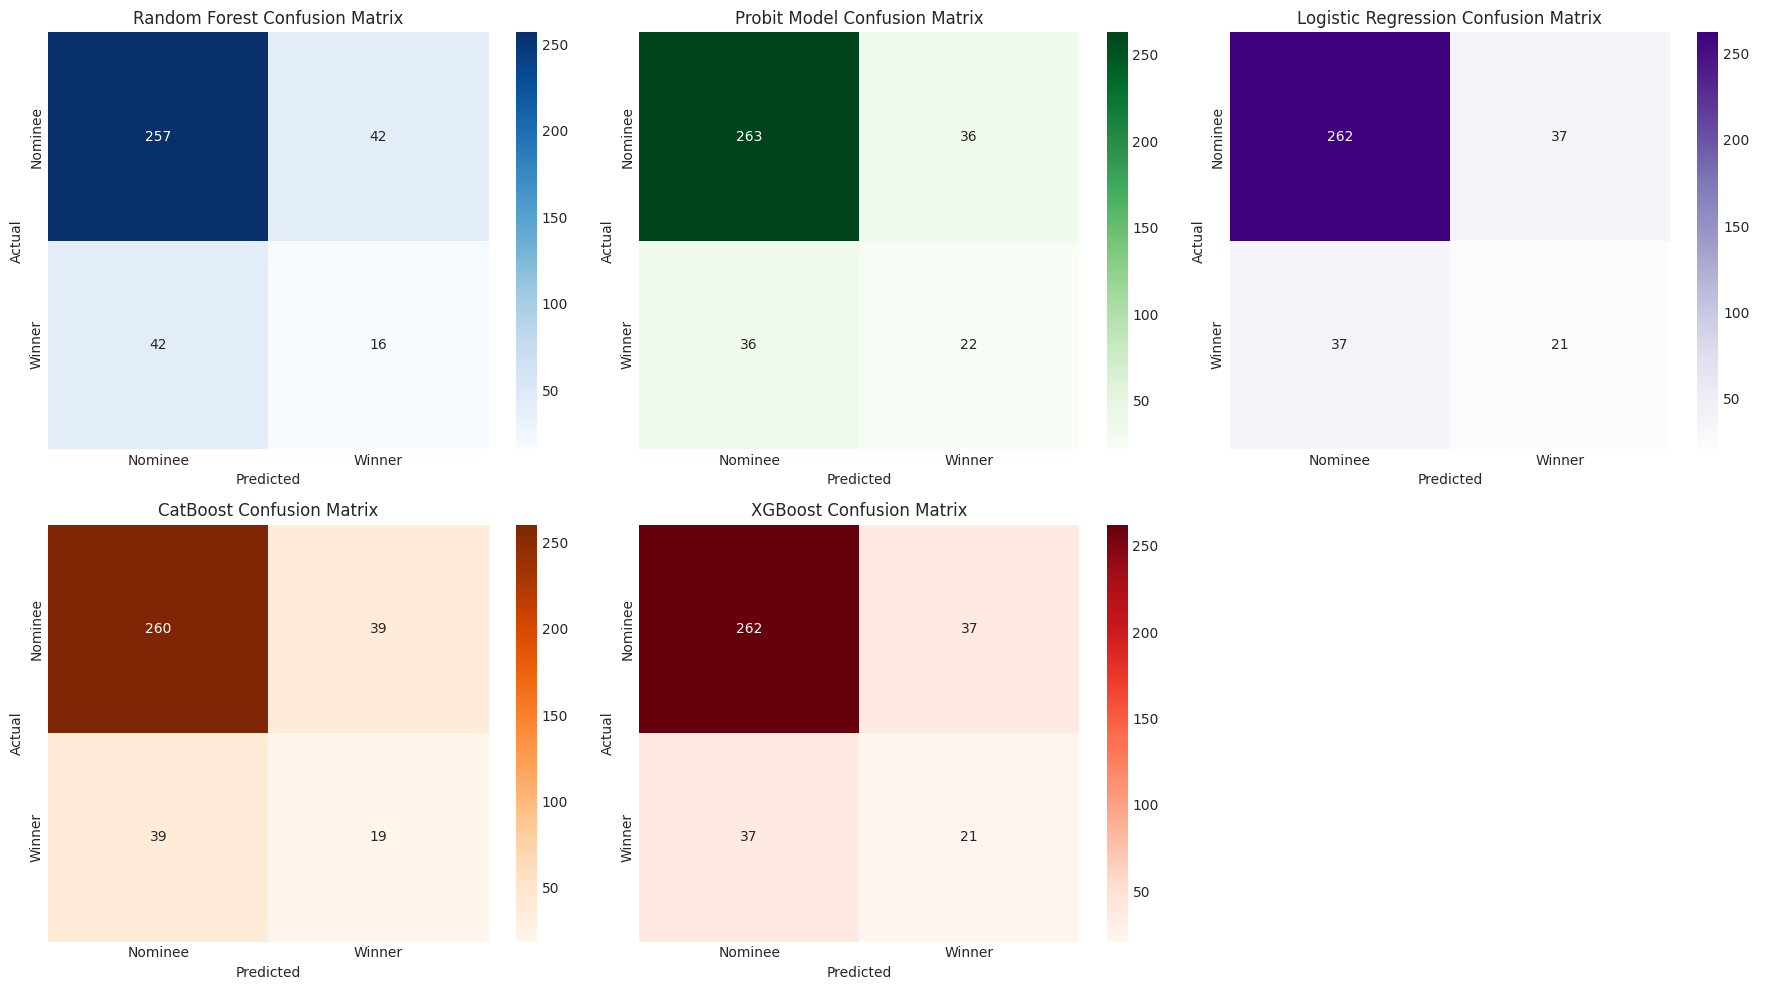

In [28]:
# Confusion Matrices for All Five Models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

y_true = combined_results['Actual_Winner'].values

# Random Forest Confusion Matrix
y_pred_rf = combined_results['RF_Predicted_Winner'].astype(int).values
cm_rf = confusion_matrix(y_true, y_pred_rf, labels=[0, 1])
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Nominee', 'Winner'], yticklabels=['Nominee', 'Winner'])
axes[0, 0].set_title('Random Forest Confusion Matrix')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')

# Probit Confusion Matrix
y_pred_probit = combined_results['Probit_Predicted_Winner'].astype(int).values
cm_probit = confusion_matrix(y_true, y_pred_probit, labels=[0, 1])
sns.heatmap(cm_probit, annot=True, fmt='d', cmap='Greens', ax=axes[0, 1],
            xticklabels=['Nominee', 'Winner'], yticklabels=['Nominee', 'Winner'])
axes[0, 1].set_title('Probit Model Confusion Matrix')
axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_xlabel('Predicted')

# Logistic Regression Confusion Matrix
y_pred_logistic = combined_results['Logistic_Predicted_Winner'].astype(int).values
cm_logistic = confusion_matrix(y_true, y_pred_logistic, labels=[0, 1])
sns.heatmap(cm_logistic, annot=True, fmt='d', cmap='Purples', ax=axes[0, 2],
            xticklabels=['Nominee', 'Winner'], yticklabels=['Nominee', 'Winner'])
axes[0, 2].set_title('Logistic Regression Confusion Matrix')
axes[0, 2].set_ylabel('Actual')
axes[0, 2].set_xlabel('Predicted')

# CatBoost Confusion Matrix
y_pred_catboost = combined_results['CatBoost_Predicted_Winner'].astype(int).values
cm_catboost = confusion_matrix(y_true, y_pred_catboost, labels=[0, 1])
sns.heatmap(cm_catboost, annot=True, fmt='d', cmap='Oranges', ax=axes[1, 0],
            xticklabels=['Nominee', 'Winner'], yticklabels=['Nominee', 'Winner'])
axes[1, 0].set_title('CatBoost Confusion Matrix')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_xlabel('Predicted')

# XGBoost Confusion Matrix
y_pred_xgboost = combined_results['XGBoost_Predicted_Winner'].astype(int).values
cm_xgboost = confusion_matrix(y_true, y_pred_xgboost, labels=[0, 1])
sns.heatmap(cm_xgboost, annot=True, fmt='d', cmap='Reds', ax=axes[1, 1],
            xticklabels=['Nominee', 'Winner'], yticklabels=['Nominee', 'Winner'])
axes[1, 1].set_title('XGBoost Confusion Matrix')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_xlabel('Predicted')

# Hide the empty subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


Random Forest final accuracy: 27.59%
Probit Model final accuracy: 37.93%
Logistic Regression final accuracy: 36.21%
CatBoost final accuracy: 32.76%
XGBoost final accuracy: 36.21%


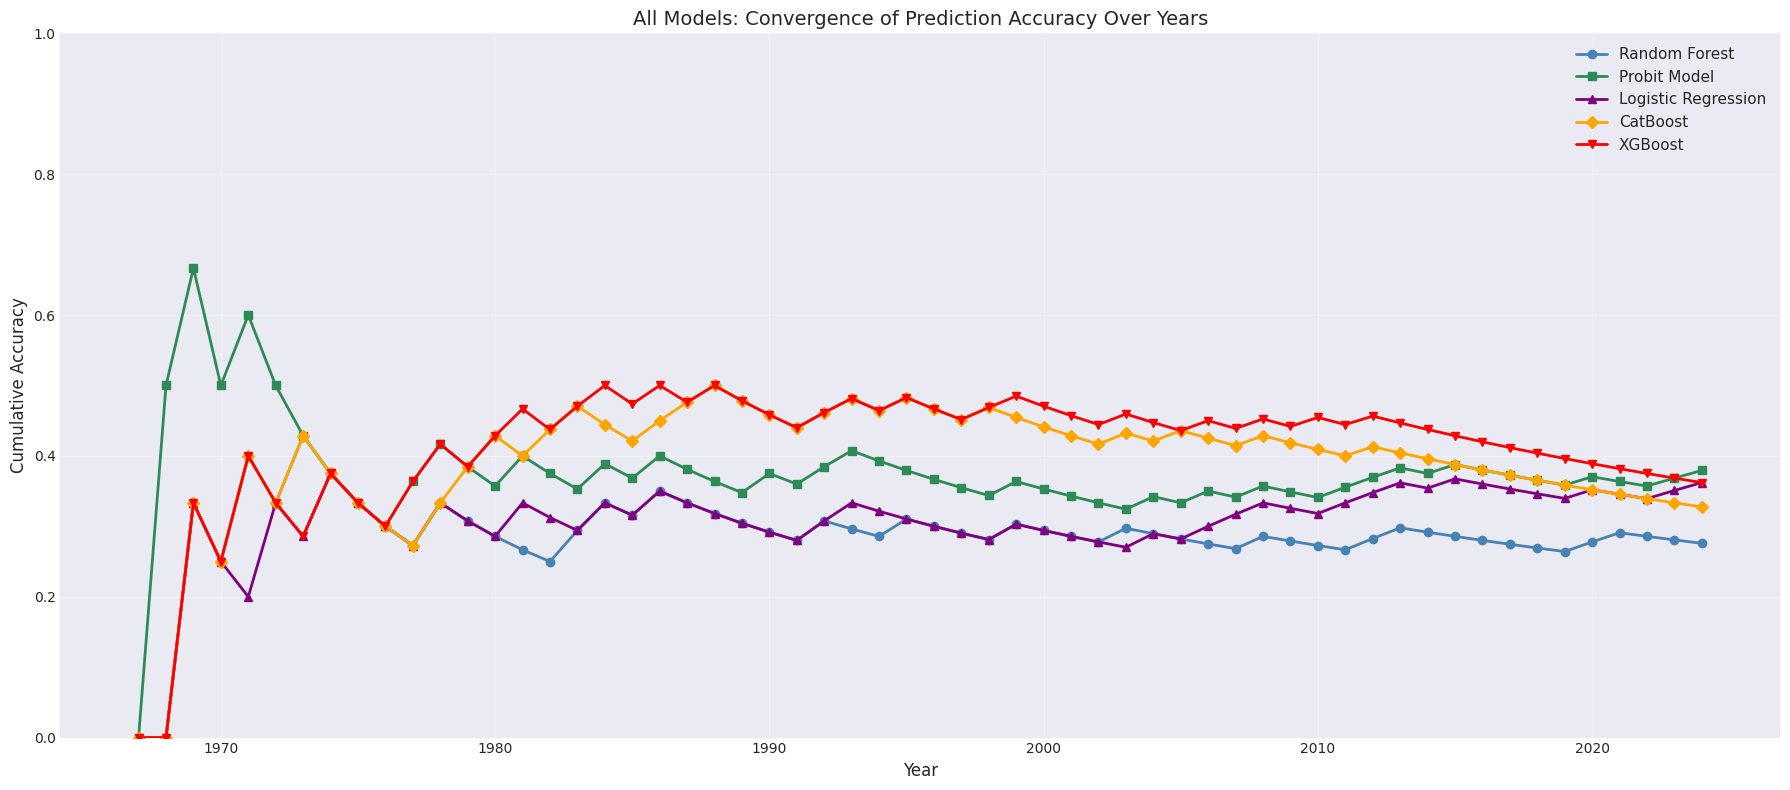

In [29]:
# Year-by-year cumulative accuracy timeline - All Five Models
years_list = sorted(combined_results['Year'].unique())

# Helper function to calculate cumulative accuracy
def calculate_cumulative_accuracy(combined_results, pred_col, years_list):
    yearly_results = []
    for year in years_list:
        year_data = combined_results[combined_results['Year'] == year]
        pred = year_data[year_data[pred_col] == True]
        actual = year_data[year_data['Actual_Winner'] == 1]
        if len(pred) > 0 and len(actual) > 0:
            correct = 1 if pred['Film'].values[0] == actual['Film'].values[0] else 0
            yearly_results.append({'Year': year, 'Correct': correct})
    
    yearly_df = pd.DataFrame(yearly_results)
    accuracy = [yearly_df[yearly_df['Year'] == y]['Correct'].values[0] 
                if y in yearly_df['Year'].values else 0 for y in years_list]
    
    cumulative_accuracy = []
    cumsum = 0
    for i, correct in enumerate(accuracy):
        cumsum += correct
        cumulative_accuracy.append(cumsum / (i + 1))
    
    return cumulative_accuracy

# Calculate cumulative accuracy for all models
rf_cumulative_accuracy = calculate_cumulative_accuracy(combined_results, 'RF_Predicted_Winner', years_list)
probit_cumulative_accuracy = calculate_cumulative_accuracy(combined_results, 'Probit_Predicted_Winner', years_list)
logistic_cumulative_accuracy = calculate_cumulative_accuracy(combined_results, 'Logistic_Predicted_Winner', years_list)
catboost_cumulative_accuracy = calculate_cumulative_accuracy(combined_results, 'CatBoost_Predicted_Winner', years_list)
xgboost_cumulative_accuracy = calculate_cumulative_accuracy(combined_results, 'XGBoost_Predicted_Winner', years_list)

# Print final accuracies
print(f"Random Forest final accuracy: {rf_cumulative_accuracy[-1]:.2%}")
print(f"Probit Model final accuracy: {probit_cumulative_accuracy[-1]:.2%}")
print(f"Logistic Regression final accuracy: {logistic_cumulative_accuracy[-1]:.2%}")
print(f"CatBoost final accuracy: {catboost_cumulative_accuracy[-1]:.2%}")
print(f"XGBoost final accuracy: {xgboost_cumulative_accuracy[-1]:.2%}")

# Plot all models together
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(years_list, rf_cumulative_accuracy, marker='o', label='Random Forest', linewidth=2, markersize=6, color='steelblue')
ax.plot(years_list, probit_cumulative_accuracy, marker='s', label='Probit Model', linewidth=2, markersize=6, color='seagreen')
ax.plot(years_list, logistic_cumulative_accuracy, marker='^', label='Logistic Regression', linewidth=2, markersize=6, color='purple')
ax.plot(years_list, catboost_cumulative_accuracy, marker='D', label='CatBoost', linewidth=2, markersize=6, color='orange')
ax.plot(years_list, xgboost_cumulative_accuracy, marker='v', label='XGBoost', linewidth=2, markersize=6, color='red')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Cumulative Accuracy', fontsize=12)
ax.set_title('All Models: Convergence of Prediction Accuracy Over Years', fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

Training final models on all data for feature importance analysis...


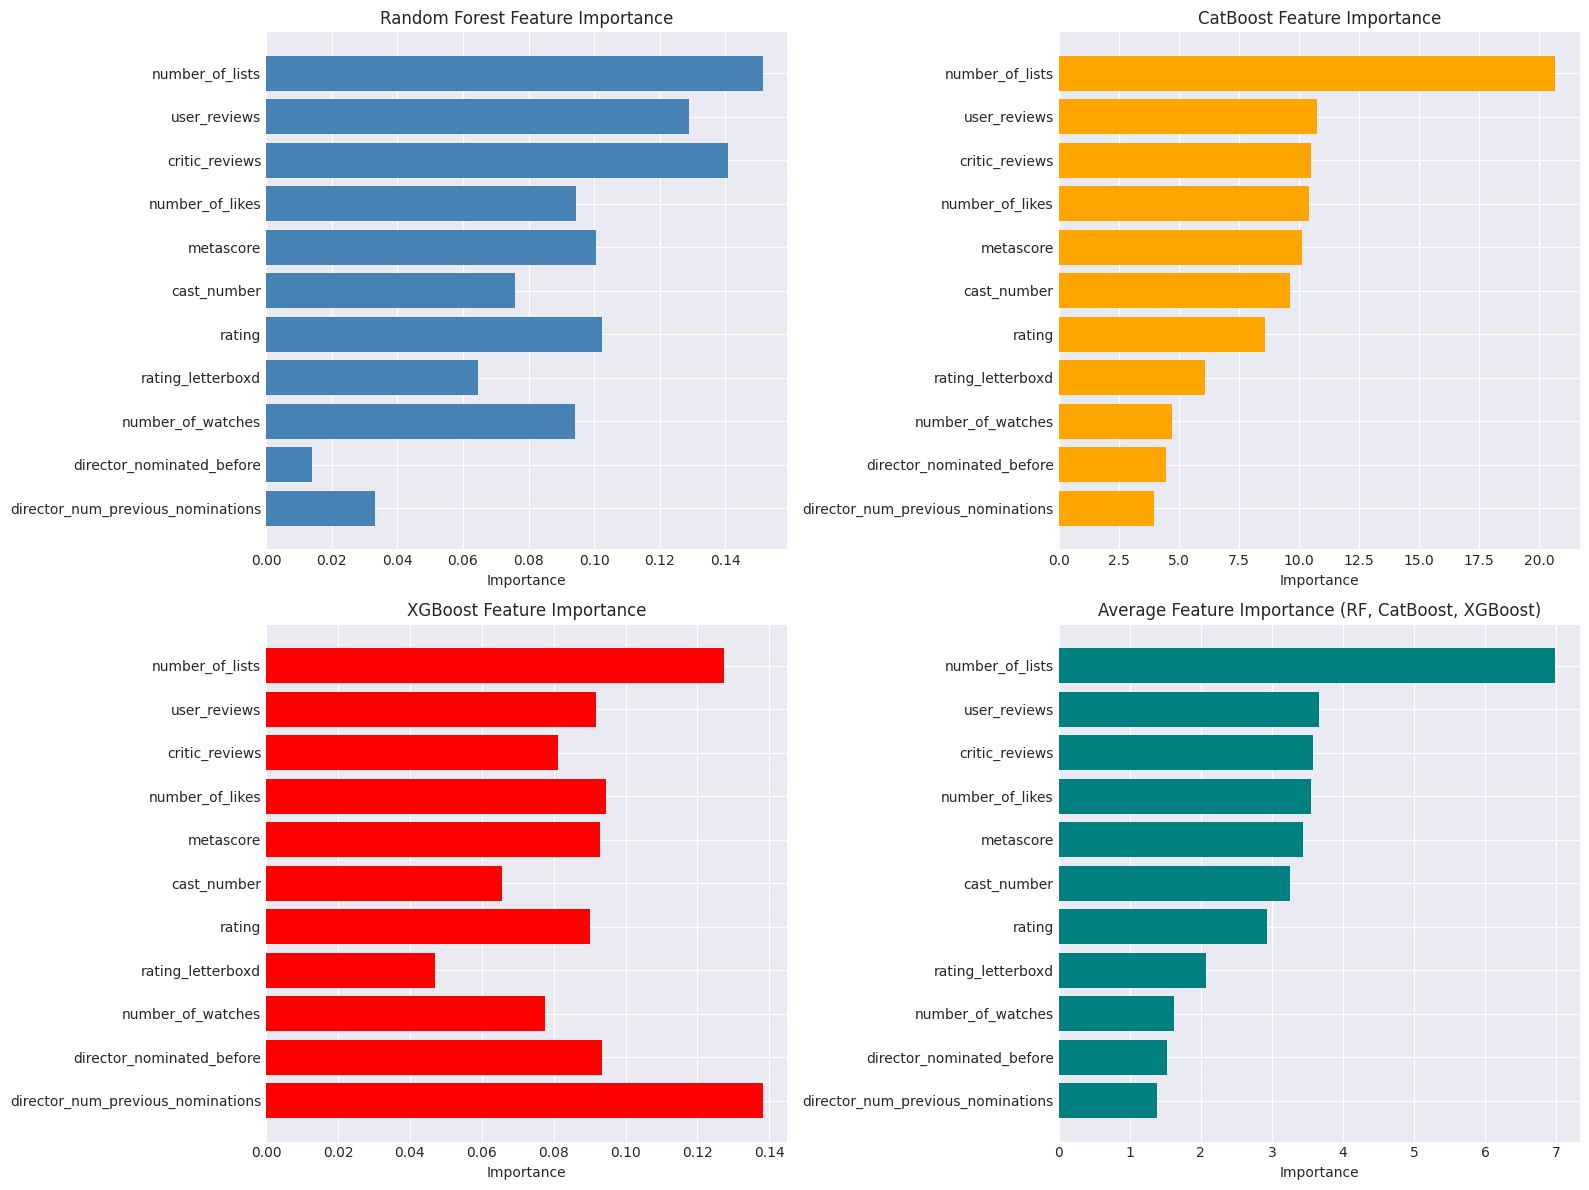


Feature Importance Summary:
                              Feature  RF_Importance  CatBoost_Importance  \
6                     number_of_lists       0.151365            20.677352   
1                        user_reviews       0.128792            10.753227   
2                      critic_reviews       0.140659            10.505269   
8                     number_of_likes       0.094354            10.443644   
3                           metascore       0.100697            10.132236   
4                         cast_number       0.075971             9.634951   
0                              rating       0.102369             8.600315   
5                   rating_letterboxd       0.064499             6.100388   
7                   number_of_watches       0.094122             4.703515   
9           director_nominated_before       0.013956             4.484964   
10  director_num_previous_nominations       0.033216             3.964139   

    XGBoost_Importance  Average_Importance  
6

In [30]:
# Feature importance from Random Forest, CatBoost, and XGBoost (train on all data for interpretation)
print("Training final models on all data for feature importance analysis...")

# Random Forest
rf_final = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)
rf_final.fit(X, y)

# CatBoost
neg_samples = (y == 0).sum()
pos_samples = (y == 1).sum()
scale_pos_weight = neg_samples / pos_samples

catboost_final = CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    verbose=0
)
catboost_final.fit(X, y)

# XGBoost
xgboost_final = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)
xgboost_final.fit(X, y)

# Get feature importances
rf_importance = pd.DataFrame({
    'Feature': available_features,
    'RF_Importance': rf_final.feature_importances_
})

catboost_importance = pd.DataFrame({
    'Feature': available_features,
    'CatBoost_Importance': catboost_final.feature_importances_
})

xgboost_importance = pd.DataFrame({
    'Feature': available_features,
    'XGBoost_Importance': xgboost_final.feature_importances_
})

# Merge all feature importances
feature_importance_combined = rf_importance.merge(catboost_importance, on='Feature').merge(xgboost_importance, on='Feature')
feature_importance_combined['Average_Importance'] = feature_importance_combined[['RF_Importance', 'CatBoost_Importance', 'XGBoost_Importance']].mean(axis=1)
feature_importance_combined = feature_importance_combined.sort_values('Average_Importance', ascending=False)

# Plot feature importance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Random Forest
axes[0, 0].barh(range(len(feature_importance_combined)), feature_importance_combined['RF_Importance'], color='steelblue')
axes[0, 0].set_yticks(range(len(feature_importance_combined)))
axes[0, 0].set_yticklabels(feature_importance_combined['Feature'])
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_title('Random Forest Feature Importance')
axes[0, 0].invert_yaxis()

# CatBoost
axes[0, 1].barh(range(len(feature_importance_combined)), feature_importance_combined['CatBoost_Importance'], color='orange')
axes[0, 1].set_yticks(range(len(feature_importance_combined)))
axes[0, 1].set_yticklabels(feature_importance_combined['Feature'])
axes[0, 1].set_xlabel('Importance')
axes[0, 1].set_title('CatBoost Feature Importance')
axes[0, 1].invert_yaxis()

# XGBoost
axes[1, 0].barh(range(len(feature_importance_combined)), feature_importance_combined['XGBoost_Importance'], color='red')
axes[1, 0].set_yticks(range(len(feature_importance_combined)))
axes[1, 0].set_yticklabels(feature_importance_combined['Feature'])
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title('XGBoost Feature Importance')
axes[1, 0].invert_yaxis()

# Average Importance
axes[1, 1].barh(range(len(feature_importance_combined)), feature_importance_combined['Average_Importance'], color='teal')
axes[1, 1].set_yticks(range(len(feature_importance_combined)))
axes[1, 1].set_yticklabels(feature_importance_combined['Feature'])
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Average Feature Importance (RF, CatBoost, XGBoost)')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\nFeature Importance Summary:")
print(feature_importance_combined[['Feature', 'RF_Importance', 'CatBoost_Importance', 'XGBoost_Importance', 'Average_Importance']])


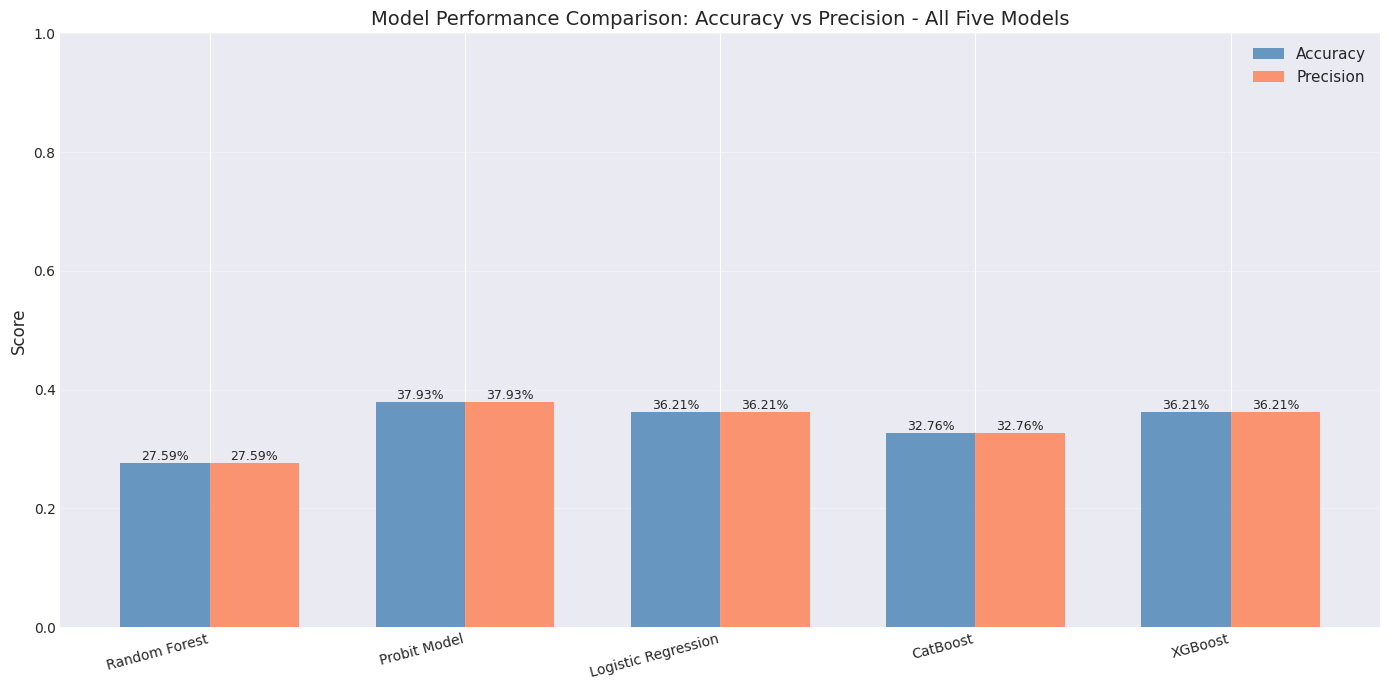

In [31]:
# Model comparison bar chart - All Five Models
fig, ax = plt.subplots(figsize=(14, 7))

models = ['Random Forest', 'Probit Model', 'Logistic Regression', 'CatBoost', 'XGBoost']
accuracy_scores = [
    rf_metrics['Accuracy (Year-by-Year)'], 
    probit_metrics['Accuracy (Year-by-Year)'],
    logistic_metrics['Accuracy (Year-by-Year)'],
    catboost_metrics['Accuracy (Year-by-Year)'],
    xgboost_metrics['Accuracy (Year-by-Year)']
]
precision_scores = [
    rf_metrics['Precision'], 
    probit_metrics['Precision'],
    logistic_metrics['Precision'],
    catboost_metrics['Precision'],
    xgboost_metrics['Precision']
]

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, precision_scores, width, label='Precision', alpha=0.8, color='coral')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison: Accuracy vs Precision - All Five Models', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend(fontsize=11)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


# 10. Save Results

Exporting predictions and model performance metrics for all five models to CSV for further analysis.


In [32]:
# Save combined predictions to CSV (all five models)
output_file = '/workspaces/DataDriveOscarProject/DataAnalysis/oscar_predictions_results_all_models.csv'
combined_results.to_csv(output_file, index=False)
print(f"Predictions saved to: {output_file}")

# Save model performance metrics (all five models)
metrics_file = '/workspaces/DataDriveOscarProject/DataAnalysis/model_performance_metrics_all_models.csv'
metrics_comparison.to_csv(metrics_file)
print(f"Metrics saved to: {metrics_file}")

# Save feature importance (RF, CatBoost, XGBoost)
feature_importance_file = '/workspaces/DataDriveOscarProject/DataAnalysis/feature_importance_combined.csv'
feature_importance_combined.to_csv(feature_importance_file, index=False)
print(f"Feature importance saved to: {feature_importance_file}")


Predictions saved to: /workspaces/DataDriveOscarProject/DataAnalysis/oscar_predictions_results_all_models.csv
Metrics saved to: /workspaces/DataDriveOscarProject/DataAnalysis/model_performance_metrics_all_models.csv
Feature importance saved to: /workspaces/DataDriveOscarProject/DataAnalysis/feature_importance_combined.csv


# Summary and Conclusions

## Key Findings

This analysis built and evaluated five predictive models for Oscar Best Picture winners:

### Model Performance
- All models used cumulative training (training on all historical data up to each year)
- Features included IMDB ratings, user/critic reviews, metascores, Letterboxd ratings, engagement metrics, and director nomination history
- Missing values were imputed using mean values

### Random Forest Classifier
- Ensemble learning approach with 300 trees
- Handles non-linear relationships well
- Provides feature importance rankings

### Probit Model
- Probabilistic linear model based on normal distribution
- Provides interpretable coefficients
- Good for understanding linear relationships

### Logistic Regression
- Classic linear classification model
- Interpretable and fast to train
- Uses standardized features

### CatBoost
- Gradient boosting algorithm optimized for categorical features
- Robust to overfitting
- Handles class imbalance with scale_pos_weight

### XGBoost
- Popular gradient boosting implementation
- High performance and speed
- Provides feature importance

## Next Steps
1. Feature engineering: Add categorical features (genres, studios)
2. Hyperparameter tuning for better performance
3. Try ensemble methods combining multiple models
4. Analyze prediction errors to understand model weaknesses
5. Consider temporal trends and era-specific patterns


In [33]:
# Final Summary
print("="*80)
print("OSCAR WINNER PREDICTION ANALYSIS - COMPLETE")
print("="*80)
print(f"\nDataset: {len(df)} films across {df['Year of Film Release'].nunique()} ceremonies")
print(f"Features used: {len(available_features)}")
print(f"Years evaluated: {len(combined_results['Year'].unique())}")
print("\nMODEL PERFORMANCE SUMMARY:")
print(f"\n  Random Forest:")
print(f"    - Accuracy: {rf_metrics['Accuracy (Year-by-Year)']:.2%}")
print(f"    - Precision: {rf_metrics['Precision']:.2%}")
print(f"\n  Probit Model:")
print(f"    - Accuracy: {probit_metrics['Accuracy (Year-by-Year)']:.2%}")
print(f"    - Precision: {probit_metrics['Precision']:.2%}")
print(f"\n  Logistic Regression:")
print(f"    - Accuracy: {logistic_metrics['Accuracy (Year-by-Year)']:.2%}")
print(f"    - Precision: {logistic_metrics['Precision']:.2%}")
print(f"\n  CatBoost:")
print(f"    - Accuracy: {catboost_metrics['Accuracy (Year-by-Year)']:.2%}")
print(f"    - Precision: {catboost_metrics['Precision']:.2%}")
print(f"\n  XGBoost:")
print(f"    - Accuracy: {xgboost_metrics['Accuracy (Year-by-Year)']:.2%}")
print(f"    - Precision: {xgboost_metrics['Precision']:.2%}")
print("\nOUTPUT FILES:")
print(f"  - {output_file}")
print(f"  - {metrics_file}")
print(f"  - {feature_importance_file}")
print("="*80)


OSCAR WINNER PREDICTION ANALYSIS - COMPLETE

Dataset: 612 films across 97 ceremonies
Features used: 11
Years evaluated: 58

MODEL PERFORMANCE SUMMARY:

  Random Forest:
    - Accuracy: 27.59%
    - Precision: 27.59%

  Probit Model:
    - Accuracy: 37.93%
    - Precision: 37.93%

  Logistic Regression:
    - Accuracy: 36.21%
    - Precision: 36.21%

  CatBoost:
    - Accuracy: 32.76%
    - Precision: 32.76%

  XGBoost:
    - Accuracy: 36.21%
    - Precision: 36.21%

OUTPUT FILES:
  - /workspaces/DataDriveOscarProject/DataAnalysis/oscar_predictions_results_all_models.csv
  - /workspaces/DataDriveOscarProject/DataAnalysis/model_performance_metrics_all_models.csv
  - /workspaces/DataDriveOscarProject/DataAnalysis/feature_importance_combined.csv
